In [1]:
import pandas as pd
from  decouple import Config,RepositoryEnv


#Set API Keys and File_path
config = Config(RepositoryEnv(".env"))
file_path = "/Users/jacobfletcher/git/churn_project/data/mini_selected_features.csv"

# sklearn Model Trainer Class

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import comet_ml

import matplotlib.pyplot as plt


class SklearnModelTrainer:
    def __init__(self, model_name,model, file_path=None,logging=True) -> None:
        self.model_name = model_name
        self.model = model
        self.experiment = None
        self.file_path = file_path
        self.df  = pd.read_csv(file_path) 
        self.logging = logging
    
    def model_data_prep(self):
        drop_cols = ["Unamed: 0", "userId"]

        for col in drop_cols:
            if col in self.df.columns:
                self.df = self.df.drop([col], axis=1)
        
        self.df = self.df.fillna(0)
        return self 

    def iniate_comet(self):
        if self.logging == True:
            self.experiment = comet_ml.Experiment(
                api_key=config("COMET_API"),
                project_name=config("PROJECT_NAME"),
                workspace=config("WORKSPACE"),
            )
        return self

    def normalize_dataframe(self,df, columns_to_normalize=None):
        if columns_to_normalize is None:
            columns_to_normalize = df.select_dtypes(
                include=["float64", "int64"]
            ).columns.tolist()

        scaler = MinMaxScaler()
        df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

        return df
    

    def plot_conf_matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        # Create a new figure for each plot
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        
        # Set the title for the entire figure
        fig.suptitle(f"Confusion Matrix - {self.model_name}", fontsize=16)

        # Show the figure
        plt.show()


    def score_metrics(self, y_pred, y_test):
        f1 = f1_score(y_pred=y_pred, y_true=y_test)
        precision = precision_score(y_pred=y_pred, y_true=y_test)
        recall = recall_score(y_pred=y_pred, y_true=y_test)
        metrics = {"f1": f1, "recall": recall, "precision": precision}

        return metrics

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(
           self.df.drop("label", axis=1), self.df["label"], train_size=0.8, random_state=42
        )
        return X_train, X_test, y_train, y_test

    def build_params(self):
        params = {
            "model_name": self.model_name,
            "model": self.model,
            "model_params": self.model.get_params(),
            "data_source": self.file_path,  # Use self.file_path
        }
        return params

    def comet_logger(self, metrics, y_test, y_pred):
        self.experiment.log_metrics(metrics)
        self.experiment.log_parameters(self.build_params())

        self.experiment.log_confusion_matrix(
            y_true=y_test.tolist(),
            y_predicted=y_pred.tolist(),
            step=0,
            title="Confusion Matrix",
            file_name="confusion-matrix-%03d.json" % 0,
        )

    def train_and_predict(self):
        self.model_data_prep()
        X_train, X_test, y_train, y_test = self.split_data()
        X_train = self.normalize_dataframe(X_train)
        X_test = self.normalize_dataframe(X_test)
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)

        return y_pred, y_test, self.model
    
    def evaluate_and_log_metrics(self, y_pred, y_test):
        self.metrics = self.score_metrics(y_pred=y_pred, y_test=y_test)
        self.plot_conf_matrix(y_pred=y_pred, y_test=y_test)
        if self.logging == True:
            self.comet_logger(
                metrics=self.metrics,
                y_test=y_test,
                y_pred=y_pred
            )
            
            self.experiment.end()
        return self.metrics

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

trainer_plan = {
    "LogisticRegression": LogisticRegression(
        class_weight="balanced", solver="liblinear", random_state=42
    ),
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=300, max_depth=25, min_samples_split=2, random_state=42
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    "SupportVectorClassifier": SVC(C=1.0, kernel="rbf", gamma="scale", random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5, weights="uniform", algorithm="auto"),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        learning_rate=1.0,
        random_state=42,
    ),
    "BaggingClassifier": BaggingClassifier(
        base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42
    ),
    "Gaussian_Naive_Bayes": GaussianNB(),
}


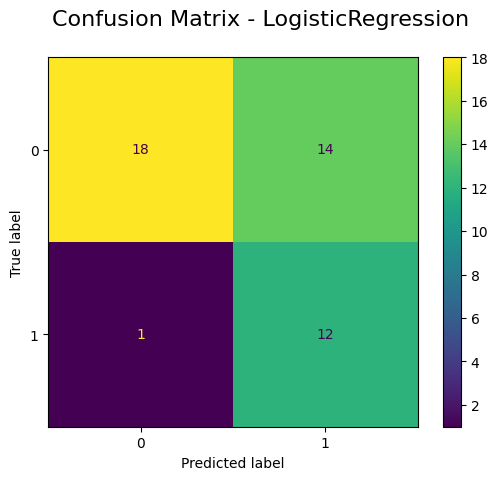

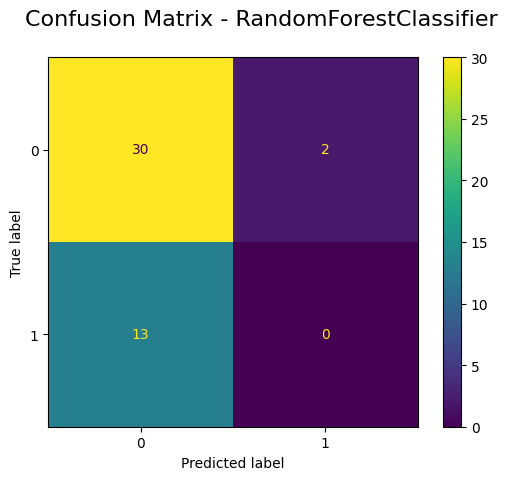

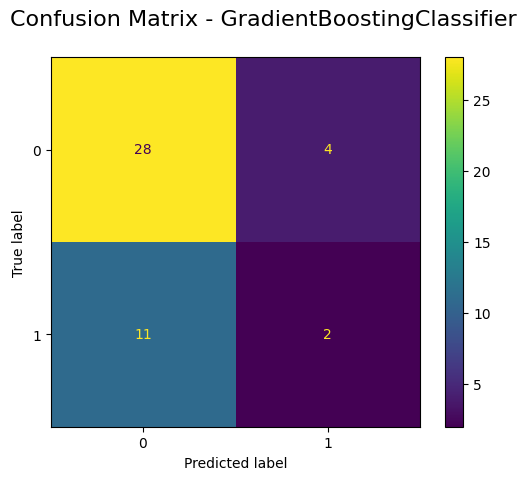

/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


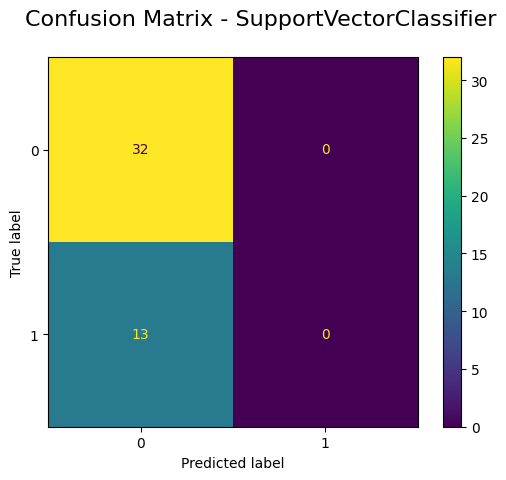

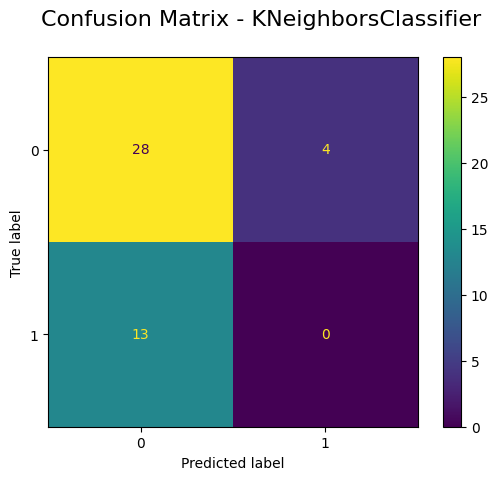

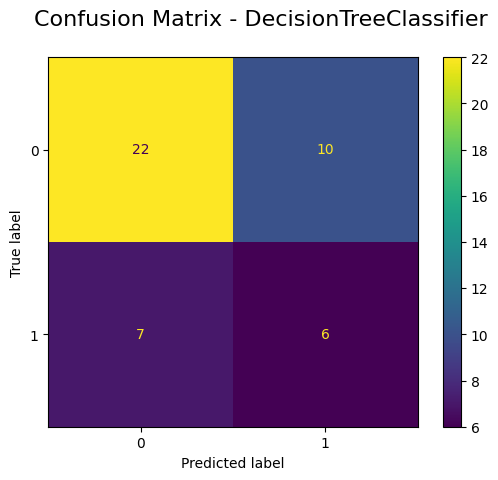

/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


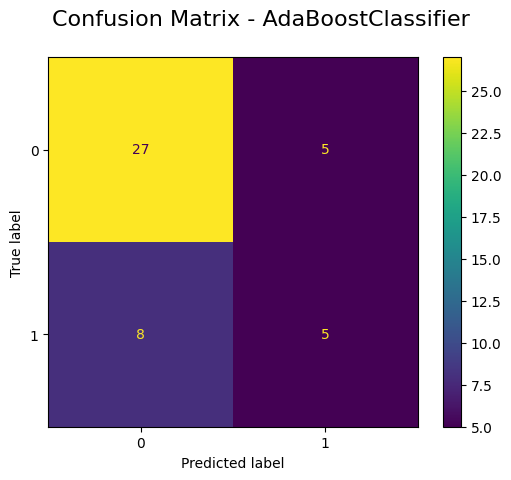

/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


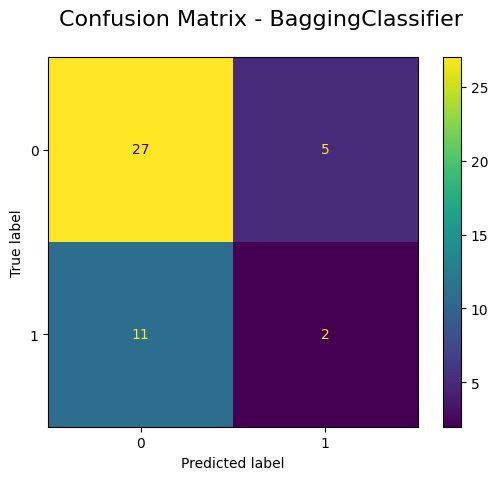

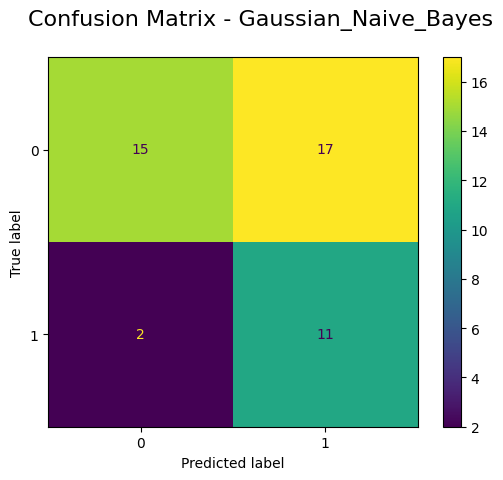

In [109]:
#Build Dict for Quick Preforance Review
performance ={}
#Iterate through Model in Model plan
for model_name in trainer_plan:
    model_trainer = SklearnModelTrainer(model_name=model_name, model=trainer_plan[model_name],file_path=file_path,logging=False)
    model_trainer.iniate_comet()
    y_pred, y_test, trained_model =model_trainer.train_and_predict()
    metrics = model_trainer.evaluate_and_log_metrics(y_pred, y_test)
    performance[model_name] = metrics

In [110]:
  
df = pd.DataFrame.from_dict(performance, orient='index')
df.sort_values('f1', ascending=False)


,f1,recall,precision
LogisticRegression,0.615385,0.923077,0.461538
Gaussian_Naive_Bayes,0.536585,0.846154,0.392857
AdaBoostClassifier,0.434783,0.384615,0.500000
DecisionTreeClassifier,0.413793,0.461538,0.375000
GradientBoostingClassifier,0.210526,0.153846,0.333333
BaggingClassifier,0.200000,0.153846,0.285714
RandomForestClassifier,0.000000,0.000000,0.000000
SupportVectorClassifier,0.000000,0.000000,0.000000
KNeighborsClassifier,0.000000,0.000000,0.000000
